In [ ]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Functions

In [ ]:
def cleanTxt(txt):
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing R
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    txt = re.sub('\r\n', '', txt)
    txt = re.sub('amp', '', txt) # removing ampersand
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [ ]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'data']
    txt_lst = [word for word in txt_lst if word != 'privacy']
    txt_lst = [word for word in txt_lst if word != 'u']
    return " ".join(txt_lst)

In [ ]:
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(text_vec)
    return estimator_kmeans.inertia_

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent = "geoapiExercises")
geocode = RateLimiter(geolocator.geocode, max_retries=2, swallow_exceptions=True, return_value_on_exception=None)
def findCountry(txt):
    if txt is np.nan:
        return 'Unknown'
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    if 'global' in txt.lower() or 'worldwide' in txt.lower(): # over 100 entries with global or worldwide as location
        return 'Global'
    txt_lst = txt.split(" ")
    for word in txt_lst:  # a few entries that return unknown when a number is present (regex doesn't remove it for some reason)
        if any(ch.isdigit() for ch in word):
            txt_lst.remove(word)
    txt = " ".join(txt_lst)
    try:
        x = geolocator.geocode(txt, )
        if x is None:
            return 'Unknown'
        loc = x.address.split(',')[-1]
        if loc[0] == " ":
            loc = loc[1:]
        return loc
    except:
        return 'Unknown'

In [ ]:
def splitData(data, len_of_frame):
    n = len(data.index) 
    split_n = round(n/len_of_frame, 0)
    print(split_n)
    splits = [int(x) for x in range(int(split_n))]
    lst = []
    for splt in splits:
        if splt == splits[-1]:
            lst.append(data[int(splt * len_of_frame):])
        else:
            lst.append(data[int(splt * len_of_frame):int(len_of_frame * (1 + splt))])
    return lst

In [ ]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [ ]:
# we can make a function that puts comparisons side by side so its easier for us to see in a data frame 

def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, df2))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [ ]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [ ]:
def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

# Data Privacy Tweets

In [ ]:
data = pd.read_csv('data_privacy_tweets.csv')

In [ ]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1166589525386301440,x1404485195676459008,2021-06-14 17:05:39,privacy_issues,The @EFF finds that the proposed modifications...,TweetDeck,248,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
1,x1166589525386301440,x1403010409473449986,2021-06-10 15:25:22,privacy_issues,The European Parliament passes the new #EU #CO...,TweetDeck,223,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
2,x1166589525386301440,x1404185087093182465,2021-06-13 21:13:07,privacy_issues,To gain better control over the increasingly p...,TweetDeck,240,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
3,x1166589525386301440,x1401833811940306947,2021-06-07 09:30:00,privacy_issues,What if the consumers are on the driving seat ...,TweetDeck,255,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
4,x1166589525386301440,x1401555697163280387,2021-06-06 15:04:52,privacy_issues,"""Vera Jourová says new rules are needed to lim...",TweetDeck,230,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...


In [ ]:
data['account_created_at'] = pd.to_datetime(data['account_created_at'])

In [ ]:
import datetime

In [ ]:
datetime.datetime.now() - data['account_created_at'].mean()

Timedelta('2752 days 03:05:07.092678480')

In [ ]:
data['account_created_at'].min()

Timestamp('2006-07-13 01:27:10')

In [ ]:
data['account_created_at'].max()

Timestamp('2021-06-13 13:58:44')

In [ ]:
data.user_id.nunique()
# we hvae 7243 unique users here

7243

In [ ]:
data.shape

(10637, 90)

In [ ]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count"]]

In [ ]:
df.head()

,text,is_quote,is_retweet,retweet_count,hashtags,followers_count
0,The @EFF finds that the proposed modifications...,False,False,0,COVID,406
1,The European Parliament passes the new #EU #CO...,False,False,0,EU COVID19 GDPR,406
2,To gain better control over the increasingly p...,False,False,0,China datasharing datasecurity,406
3,What if the consumers are on the driving seat ...,False,False,1,privacypolicy tech DataPrivacy innovation Priv...,406
4,"""Vera Jourová says new rules are needed to lim...",False,False,1,EU US,406


In [ ]:
text = df[["text"]][:10000] # using subset for now so it will run faster
pd.set_option('display.max_colwidth', -1)
text.head()

,text
0,"The @EFF finds that the proposed modifications to the HIPAA would ""invade your most personal and intimiate health data."" \r\n\r\nStating that trust in healthcare is crucial and especially so during the #COVID pandemic.\r\n\r\nRead more: https://t.co/ReuoQ3mF9p"
1,The European Parliament passes the new #EU #COVID19 Certificate Regulation detailing peoples' COVID information.\r\n\r\nPromising that all personal data will be processed in line with the #GDPR\r\n\r\nRead more: https://t.co/8PGuChsV5F
2,"To gain better control over the increasingly powerful technology sector in #China, new regulations in China make it harder for big tech to refuse the government's request for #datasharing. \r\n\r\n#datasecurity\r\n\r\nRead more: https://t.co/piSfs3NW4J"
3,What if the consumers are on the driving seat to agree or disagree to the #privacypolicy of the #tech giants? Article by Beth Magnuson\r\nexplains #DataPrivacy &amp; #innovation on @VentureBeat \r\n\r\nhttps://t.co/n2pFOwWSmi\r\n\r\n#PrivacyTech #Technology #DataPrivacy
4,"""Vera Jourová says new rules are needed to limit the bulk collection of Europeans’ data.""\r\n\r\nThe #EU is requiring new legislation limiting #US government agencies from accessing European data. \r\n\r\nRead more at: https://t.co/04avhPjhCd"


# Data cleaning

In [ ]:
wnet = WordNetLemmatizer()
port = PorterStemmer()

In [ ]:
text['text'] = text['text'].apply(cleanTxt)
text.head()

,text
0,the eff finds that the proposed modifications to the hipaa would invade your most personal and intimiate health data stating that trust in healthcare is crucial and especially so during the covid pandemicread more
1,the european parliament passes the new eu covid19 certificate regulation detailing peoples covid informationpromising that all personal data will be processed in line with the gdprread more
2,to gain better control over the increasingly powerful technology sector in china new regulations in china make it harder for big tech to refuse the governments request for datasharing datasecurityread more
3,what if the consumers are on the driving seat to agree or disagree to the privacypolicy of the tech giants article by beth magnusonexplains dataprivacy innovation on venturebeat
4,vera jourová says new rules are needed to limit the bulk collection of europeans datathe eu is requiring new legislation limiting us government agencies from accessing european data read more at


In [ ]:
text['text'] = text['text'].apply(stopWords)
text.head()

,text
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read


# Vectorizing Data

Vectorizing using Binary Term Frequency (https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685). Binary Term Frequency captures presence (1) or absence (0) of term in document. For this part, under TfidfVectorizer, we set binary parameter equal to true so that it can show just presence (1) or absence (0) and norm parameter equal to false.

In [ ]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5]

['eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread',
 'european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread',
 'gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread',
 'consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat',
 'vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read']

In [ ]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [ ]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,0001860173,007cybersecurity,01,010,0100,020,05,050,06,0613you,...,zoomecertificates,zoominfo,zootokenio,zscaler,zuboff,zuck,zuckerberg,zumbullaw,zunit14,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# List of Words

In [ ]:
dp_words = [] # dp for data privacy

for row in text['text']:
    for word in str(row).split(" "):
        dp_words.append(word)
        
dp_words[:5]

['eff', 'find', 'proposed', 'modification', 'hipaa']

In [ ]:
len(dp_words)

150831

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in dp_words:
    fdist[word]+=1
fdist

FreqDist({'new': 1138, 'apple': 1069, 'security': 1060, 'user': 873, 'protection': 657, 'policy': 626, 'company': 620, 'personal': 610, 'law': 610, 'concern': 557, ...})

In [ ]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))

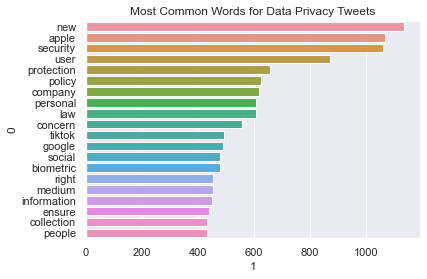

In [ ]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))
rel = sns.barplot(data = freq_data, x = 1, y = 0).set(title='Most Common Words for Data Privacy Tweets')

In [ ]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
most_common

['new',
 'apple',
 'security',
 'user',
 'protection',
 'policy',
 'company',
 'personal',
 'law',
 'concern',
 'tiktok',
 'google',
 'social',
 'biometric',
 'right',
 'medium',
 'information',
 'ensure',
 'collection',
 'people']

# Clustering

In [ ]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 35]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

In [ ]:
results_k

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();
# try 2, 3, 8 clusters.

## Cluster Analysis

In [ ]:
estimator_kmeans = KMeans(random_state=42, n_clusters=4) # we're sticking with 4
estimator_kmeans.fit(text_vec)

In [ ]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

In [ ]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

In [ ]:
text_clusters_20 = text_clusters[['new',
 'apple',
 'security',
 'user',
 'protection',
 'policy',
 'company',
 'personal',
 'law',
 'concern',
 'tiktok',
 'google',
 'social',
 'biometric',
 'right',
 'medium',
 'information',
 'ensure',
 'collection',
 'people']
]

text_clusters_20.head()

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);

# <span style="color:#748A5C">Sentiment Analysis</span>

In [ ]:
text_desc = text[["text"]]

In [ ]:
text_desc.head()

,text
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read


In [ ]:
text_desc.shape

(10000, 1)

In [ ]:
text_desc["description"] = data[["description"]][:10000]
text_desc.head()

,text,description
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,bi-monthly newsletter on #privacy #design #product #technology & more by @MiraNova_Tweet & the team. We are open for collabs. All info via DM.
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,bi-monthly newsletter on #privacy #design #product #technology & more by @MiraNova_Tweet & the team. We are open for collabs. All info via DM.
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,bi-monthly newsletter on #privacy #design #product #technology & more by @MiraNova_Tweet & the team. We are open for collabs. All info via DM.
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,bi-monthly newsletter on #privacy #design #product #technology & more by @MiraNova_Tweet & the team. We are open for collabs. All info via DM.
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,bi-monthly newsletter on #privacy #design #product #technology & more by @MiraNova_Tweet & the team. We are open for collabs. All info via DM.


In [ ]:
text_desc = text_desc.dropna()
# some rows are dropped

In [ ]:
text_desc.shape

(9488, 2)

In [ ]:
text_desc.tail()

,text,description
10159,streamlytics belief letting user sell could help reduce ai bias aim democratise giving user control selling usersupplied enterprise,Ecosystem Builder | CEO @AlchemyCrewLtd | Co-editor @InsurTECH_Book | #InsurTech #AI #DigitalTransformation #Sustainability #50insurTech
10162,epc4878 thanks bringing matter kindly dm name contact number provided placed order please reminded policy sending personal detail may refer,"Dedicated to all of our fans who say, ‘love ko ‘to.’"
10163,really interesting post dorothea salo story university library also story teaching process learning student,"Instructional Consultant @uwmadison. Ph.D. in Lit Studies. Passionate about #OER, #openpedagogy, 19th c. participatory culture, and #SoTL. Opinions my own."
10164,miss flyshotincs session mgsoptimize download session learn leverage new privacypreserving promo redemption method boost conversion rate 6 optimize using privacyfriendly deterministic ios14 u0001f4f2,<U+0001F4CD>|#MobileMarketing #MobileApps #FinTech & more\r\n<U+0001F4E1>|Frontline content and community events for mobile marketers \r\n<U+26D3>|Join the LARGEST community of mobile experts
10165,omarsar0 handle ml project,Artificial Intelligence Specialist


In [ ]:
text_desc["description"] = text_desc["description"].apply(cleanTxt)

In [ ]:
text_desc['description'] = text_desc['description'].apply(stopWords)

In [ ]:
text_desc.head()

,text,description
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,bimonthly newsletter design product technology miranovatweet team open collabs info via dm
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,bimonthly newsletter design product technology miranovatweet team open collabs info via dm


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()
text_desc['scores'] = text_desc['text'].apply(lambda review: sid_obj.polarity_scores(review))

In [ ]:
text_desc.head()

,text,description,scores
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}"
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}"
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}"
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [ ]:
text_desc['compound']  = text_desc['scores'].apply(lambda score_dict: score_dict['compound'])
text_desc.head()

,text,description,scores,compound
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}",0.5106
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}",0.7845
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}",0.3612
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000


In [ ]:
text_desc['comp_score'] = text_desc['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))

text_desc.head()

,text,description,scores,compound,comp_score
0,eff find proposed modification hipaa would invade personal intimiate health stating trust healthcare crucial especially covid pandemicread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5106}",0.5106,pos
1,european parliament pass new eu covid19 certificate regulation detailing people covid informationpromising personal processed line gdprread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2,gain better control increasingly powerful technology sector china new regulation china make harder big tech refuse government request datasharing datasecurityread,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.081, 'neu': 0.586, 'pos': 0.333, 'compound': 0.7845}",0.7845,pos
3,consumer driving seat agree disagree privacypolicy tech giant article beth magnusonexplains dataprivacy innovation venturebeat,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.139, 'neu': 0.588, 'pos': 0.273, 'compound': 0.3612}",0.3612,pos
4,vera jourová say new rule needed limit bulk collection european datathe eu requiring new legislation limiting government agency accessing european read,bimonthly newsletter design product technology miranovatweet team open collabs info via dm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral


In [ ]:
comp_score_counts = text_desc.comp_score.value_counts()
# weirdly a good chunk of them are actually postiive

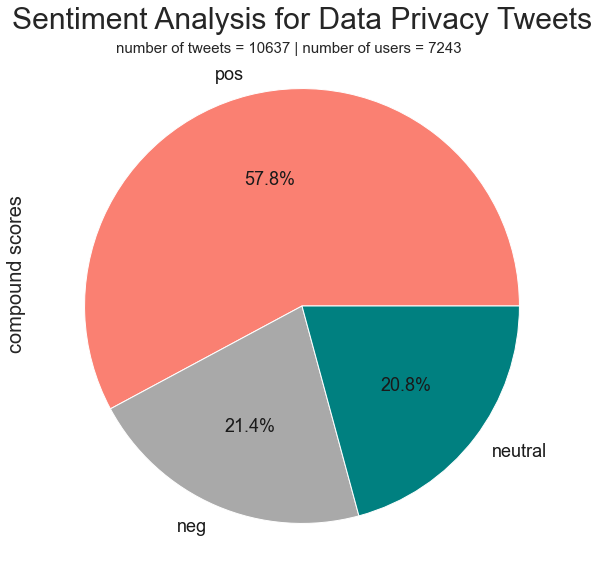

In [ ]:
colours = {'pos': 'salmon',
           'neutral': 'darkgray',
           'neg': 'teal'}
labels = ['pos','neutral', 'neg']

fig, ax = plt.subplots(figsize=(15,10))
comp_score_counts = text_desc.comp_score.value_counts()
comp_score_counts.plot.pie(autopct="%.1f%%", colors=[colours[key] for key in labels], textprops={'fontsize': 18, "color": "k"})
plt.title("Sentiment Analysis for Data Privacy Tweets", size = 30)
plt.ylabel("compound scores", size = 20, y = .56)
plt.suptitle('number of tweets = 10637 | number of users = 7243', size = 15, y = .87);

## Continued analysis including descriptions using `text_desc` dataframe
- news and opinion together
- security 
- 'tech', 'digital', 'business','technology','tweet','marketing','medium','service','law','world','view','solution','global','help','ai','software', 'cybersecurity'

### News, opinion

In [ ]:
news_df = text_desc[text_desc['description'].str.contains('news') | text_desc['description'].str.contains('opinion')]
news_df.head()

In [ ]:
news_df.shape

In [ ]:
news_comp_score_counts = news_df.comp_score.value_counts()
news_comp_score_counts.plot.pie(autopct="%.1f%%");



### Security

In [ ]:
security_df = text_desc[text_desc['description'].str.contains('security')]
security_df.head()

In [ ]:
security_df.shape

In [ ]:
security_comp_score_counts = security_df.comp_score.value_counts()
security_comp_score_counts.plot.pie(autopct="%.1f%%");

### Artifificial Intelligence

In [ ]:
any_df = text_desc[text_desc['text'].str.contains(' ai') | text_desc['text'].str.contains('ai ') |
                  text_desc['text'].str.contains('artificial intelligence')]
any_df.tail()
# nothing has artificial intelligence

,text,description,scores,compound,comp_score
10046,individual community something high priority private public actor org esp govt askencourage citizen share type ai rightscon rightscon2021,initiating inclusive conversation development digital realm founder executive editor anankemag mentor alumnus cherieblairfndn empowerwomen,"{'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.296}",0.2960,pos
10056,eu regulator tipped ai possible fault software hrtechnology,disconnect possible,"{'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}",-0.4019,neg
10061,alphabet banking obtaining substantial share ai market far lucrative current dominant share advertising market still beginning,u0001f49a abogo investigo enseño heterodox ip traditional knowledge technology bias ex jicadirect ex unito ex u5927u962au5de5u696du5927u5b66 ex absolut beginner,"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'compound': 0.6369}",0.6369,pos
10110,eu group file complaint assert clearview ai facial recognition software violates protection law,u0001f34au0001f921resisteru0001f5e3lifying theresistance myu23f1is misled reu0001f9a0bywhosotheynihdarpaiibrcan test fundedomicsu0001f9ectherapies wjcglobalreset,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.6705}",-0.6705,neg
10159,streamlytics belief letting user sell could help reduce ai bias aim democratise giving user control selling usersupplied enterprise,ecosystem builder ceo alchemycrewltd coeditor insurtechbook insurtech ai digitaltransformation sustainability 50insurtech,"{'neg': 0.065, 'neu': 0.698, 'pos': 0.237, 'compound': 0.5719}",0.5719,pos


In [ ]:
any_df.shape

(362, 5)

In [ ]:
any_df[any_df.comp_score == 'pos'].tail(10)

,text,description,scores,compound,comp_score
9581,apple double push iphone multiple new feature aiming protect user,hillreporter rawstory alternet,"{'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'compound': 0.3818}",0.3818,pos
9596,essential take account scientist use artificial intelligence analyze medical research thats energy partnering nih support ai research protects,department energy office science single largest supporter basic research physical science united state,"{'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'compound': 0.8481}",0.8481,pos
9604,ceo jarrett kolthoff led informative panel cyber insurance advantage implication gisec dubai watch full discussion,cyber counterintelligence firm protects client cyber threat proactive reactive service,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'compound': 0.25}",0.2500,pos
9623,kkjdotai pnatarajanmd noshreza andrewjsauer shwinner drkaushikjain hafizakmd purviparwani murphykmg need breakdown barrier allow free market flourish sec must remain paramount perhaps blockchain play role naturally cmsgov could monitor platform whereby ehr large small participate innovation development process,cofounder cardiac medical consulting founder capx group accelerating startup solve world challenging problem sailing enthusiast,"{'neg': 0.034, 'neu': 0.732, 'pos': 0.233, 'compound': 0.8271}",0.8271,pos
9667,beautiful airport authority want collect biometric last ounce access highly digital age say u0001f595 fuck,feminist muslim anthropologist necessarily order drug choice book music food,"{'neg': 0.167, 'neu': 0.524, 'pos': 0.31, 'compound': 0.25}",0.2500,pos
9801,apple ever decides uturn platform ai device inferencing apple vpn collect facebook could ever wish,sr director global head hardware product htcvive htc frequently caught mounting base station sticky tape opinion,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'compound': 0.4019}",0.4019,pos
9897,personal societal need require right based priority actor engaging public private sector training information encourage citizen share responsive ai rightscon rightscon2021,kijiji yeetusmart village ecosystem centered county government act 2012 villager transform village unit model based devolution kenya u0001f3e1u0001f4af,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.8555}",0.8555,pos
10046,individual community something high priority private public actor org esp govt askencourage citizen share type ai rightscon rightscon2021,initiating inclusive conversation development digital realm founder executive editor anankemag mentor alumnus cherieblairfndn empowerwomen,"{'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.296}",0.2960,pos
10061,alphabet banking obtaining substantial share ai market far lucrative current dominant share advertising market still beginning,u0001f49a abogo investigo enseño heterodox ip traditional knowledge technology bias ex jicadirect ex unito ex u5927u962au5de5u696du5927u5b66 ex absolut beginner,"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'compound': 0.6369}",0.6369,pos
10159,streamlytics belief letting user sell could help reduce ai bias aim democratise giving user control selling usersupplied enterprise,ecosystem builder ceo alchemycrewltd coeditor insurtechbook insurtech ai digitaltransformation sustainability 50insurtech,"{'neg': 0.065, 'neu': 0.698, 'pos': 0.237, 'compound': 0.5719}",0.5719,pos


In [ ]:
df.iloc[[0]]

,text,is_quote,is_retweet,retweet_count,hashtags,followers_count
0,"The @EFF finds that the proposed modifications to the HIPAA would ""invade your most personal and intimiate health data."" \r\n\r\nStating that trust in healthcare is crucial and especially so during the #COVID pandemic.\r\n\r\nRead more: https://t.co/ReuoQ3mF9p",False,False,0,COVID,406


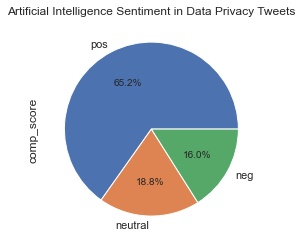

In [ ]:
any_comp_score_counts = any_df.comp_score.value_counts()
any_comp_score_counts.plot.pie(autopct="%.1f%%");
plt.title("Artificial Intelligence Sentiment in Data Privacy Tweets")
plt.show()

# Word Cloud

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
stopwords = set(STOPWORDS)
new_stopwords=stopwords.union(text['text'])
wc = WordCloud(
         background_color="white", max_words=2000,
         min_font_size =15, max_font_size=40, relative_scaling =
         0.5, stopwords=new_stopwords,normalize_plurals= True)
import re
textonly = re.sub("", "",str(text['text']))
wc.generate(textonly)
plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#Show the wordcloud
plt.show()

## finding tweets that mention google

In [ ]:
df[df['text'].str.contains("google")]

,text,is_quote,is_retweet,retweet_count,hashtags,followers_count
85,"As a long term Firefox/apple/Linux user, this resonates. I removed google from all aspects of my personal life &amp; computing years ago. Plenty of decent alternatives which respect privacy. This is a slippery slope... https://t.co/7kt0m1ouw1",False,False,0,NaN,625
1291,With Google selling your data to the highest bidder and examples like your medical records being sold off - it's time to take protecting your personal data seriously. \r\n\r\nVivaldi are taking it very seriously! \r\n\r\n#vivaldi #browsers #privacy #data #google \r\n\r\nhttps://t.co/JaXH02yzSv,False,False,0,vivaldi browsers privacy data google,398
1413,#mozilla Says #google’s New Ad Tech–FLoC–Doesn’t Protect User #privacy \r\n\r\nhttps://t.co/8DrBRXVKUx\r\n\r\n#analysis #browser #browsing #chrome #chromium #data #developer #domain #eff #facebook #malwaredevil,False,False,0,mozilla google privacy analysis browser browsing chrome chromium data developer domain eff facebook malwaredevil,113
1513,"@KingChala2 @africatechie But u are not weary of Facebook, google, Twitter, WhatsApp, IG etc that openly sell your data after invading your privacy Right? <U+196C><U+0001F602><U+1B44><U+196C><U+0001F602><U+1B44><U+196C><U+0001F602><U+1B44>our level of brainwashing is something else",False,False,0,NaN,136
1673,Mozilla Says Google's New Ad Tech—FLoC—Doesn't Protect User Privacy https://t.co/cXLOTUKEMW #mozilla #google #data #privacy,False,False,0,mozilla google data privacy,990
...,...,...,...,...,...,...
10468,It's time to ditch google chrome browser if you are care about your #privacy .\r\nhttps://t.co/1SLN4XI9dC,False,False,0,privacy,181
10720,Safest Search Engines<U+2757>\r\n\r\n#cybersecurity #infosec #informationsecurity #web #network #google #tools #ethicalhacking #hacker #hack #hunter #duckduckgo #data #cyber #security #privacy #search #turkhackteam https://t.co/Dq3JsfgQ7b,False,False,5,cybersecurity infosec informationsecurity web network google tools ethicalhacking hacker hack hunter duckduckgo data cyber security privacy search turkhackteam,320
10735,"@chassirridge this is someone who's so up on internet security/privacy concerns they'll have google blur the entire ""face"" of their building yet i'll bet they've got ring cameras, a home assistant, and any number of InternetOfShit appliances like every other nextdoor snooperino/data subject",False,False,1,NaN,1600
10741,@killedbygoogle Well yes and no.\r\n\r\nI trust them that they will keep my data private and secure. \r\n\r\nI don't trust them that they respect my privacy and therefore expect them to gather any information possible for them about me without my actual consent to it (because there's no way to consent)...<U+0001F60F>,False,False,0,NaN,292
